In [203]:
from typing import Union, List
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

# import wandb #TODO

In [239]:
random_seed = 8
np.random.seed(random_seed)
cuda = torch.cuda.is_available()
device = "cuda" if cuda else "cpu"
batch_size = 8
max_epochs = 1000
learning_rate = 0.5

# Data

In [223]:
# TODO: Later
# import sklearn.datasets
# X,y = sklearn.datasets.make_moons(200,noise=0.2) 

In [224]:
class Demo_Gaussians():
    def __init__(self, batch_size):
        scale = 4.
        centers = [(-1, 0.5),(-0.35, -0.5), (0.35, -0.5), (1, 0.5)]
        centers = [(scale * x, scale * y) for x, y in centers]

        dataset = []
        for i in range(batch_size):
            point = np.random.randn(2)*1.2
            idx = np.random.randint(4)
            center = centers[idx]
            point[0] += center[0]
            point[1] += center[1]
            dataset.append(point)
        dataset = np.array(dataset, dtype="float32")
        dataset /= 1.414
        self.dataset = torch.Tensor(dataset)
    
    def give_tensor(self):
        return self.dataset

    def plot(self):
        plt.figure(figsize=(5,5))
        x  = self.give_tensor().numpy()
        plt.hist2d(x[:,0], x[:,1],
                    range=[[-5, 5], [-5, 5]], bins=100, cmap='inferno')
        plt.xticks([])
        plt.yticks([])
        plt.xlim(-5, 5)
        plt.ylim(-5, 5)
        plt.show()

Assume 2d 4 classes

In [225]:
how_many_test = 128
how_many_train = 1024
how_many_total = how_many_train + how_many_test

In [226]:
def gen_sythetic_data(num_points: int = how_many_total, num_features: int = 2, num_classes: int = 4, balance: Union[bool, List[int]] = True):
    data = np.zeros(shape=(num_points, num_features))
    classes = np.arange(num_classes)
    if balance is True:
        balance = np.ones(num_classes) * (1/num_classes)
    labels = np.random.choice(classes, size=num_points, p=balance)
    for ind, label in enumerate(labels):
        #TODO: Generalize > 4 classes
        if label == 0:
            data[ind] = np.random.multivariate_normal(mean=np.array([-0.5,0.25]), cov=np.array([[0.1,0.05], [0.05, 0.1]]), size=1)
        elif label == 1:
            data[ind] = np.random.laplace(loc=0.5, scale=0.1, size=num_features)
        elif label == 2:
            data[ind] = np.array([np.random.uniform(low=-0.2, high=0.6), np.random.uniform(low=0.0, high=-0.4)])
        else:
            data[ind] = np.array([np.random.beta(a=2, b=2)-0.5, np.random.beta(a=2, b=5)+0.5])
    return data, labels

In [227]:
class SyntheticData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [228]:
def split_train_test(dataset, how_many_train, how_many_test):
    inds = np.arange(how_many_train + how_many_test)
    np.random.shuffle(inds)
    train_inds, test_inds = inds[how_many_test:], inds[:how_many_test]
    train_sampler = SubsetRandomSampler(train_inds)
    test_sampler = SubsetRandomSampler(test_inds)

    data_train = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    data_test = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

    return data_train, data_test

In [229]:
def plot(data: np.array, labels: np.array, x1: str, x2: str, y: str, title: str = '', save: bool = False, figname='visualize_data.png'):
    plt.figure(figsize=(14, 7))
    for label in np.unique(labels):
        plt.scatter(x=data[labels == label][:,0], y=data[labels == label][:,1], label=f'y = {label}')
    plt.title(title, fontsize=20)
    plt.legend()
    if save:
        plt.savefig(figname, dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()

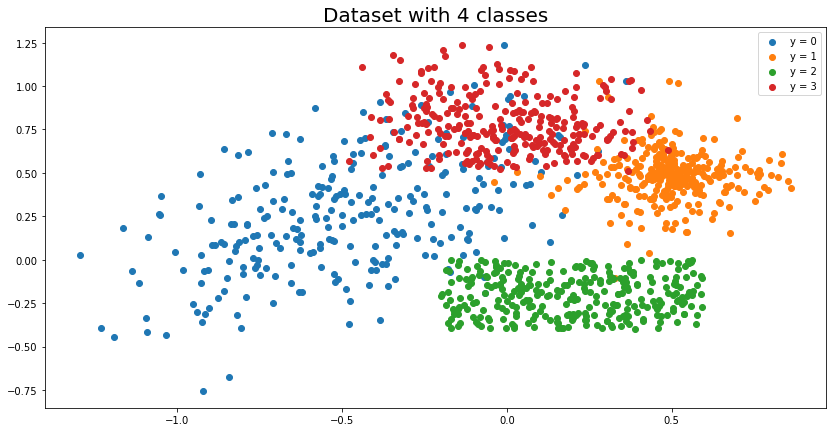

In [230]:
my_data, my_labels = gen_sythetic_data()
plot(data=my_data, labels=my_labels, x1='x1', x2='x2', y='y', title='Dataset with 4 classes')

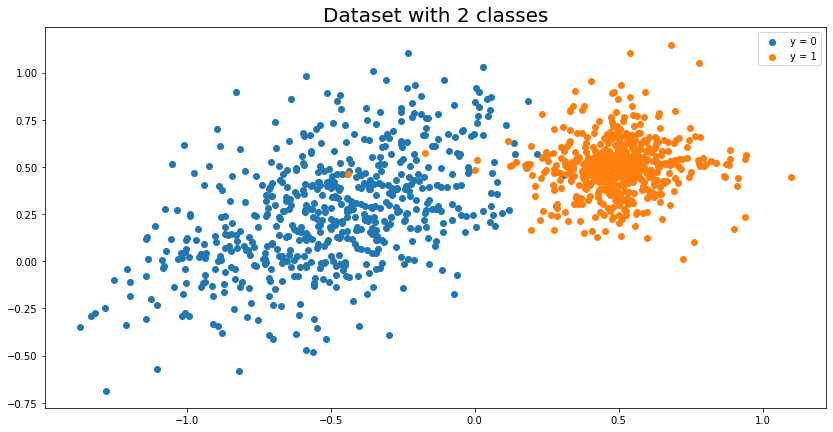

In [231]:
my_data2, my_labels2 = gen_sythetic_data(num_classes=2)
plot(data=my_data2, labels=my_labels2, x1='x1', x2='x2', y='y', title='Dataset with 2 classes')


In [232]:
train_data = SyntheticData(torch.FloatTensor(my_data2), torch.FloatTensor(my_labels2)) #LongTensor vs FloatTensor
train_loader, test_loader = split_train_test(train_data, how_many_train, how_many_test)

# Architecture

First: standard NN with 1 hidden layer

$ f(x) = \sum_{j=0}^{M-1} \beta_j \sigma(w_j^T x + b_j) $ + b

Second: Random Features so $w_j, b_j$ chosen at random

Number of parameters:

First: (2 + 1) * M + M + 1 = 4M + 1

In [233]:
class NN(nn.Module):
  """Small neural network.
  Args:
      input_dimension (int): Number of dimensions in the input.
      hidden_dimension (int): Number of dimensions in the hidden layers.
      output_dimensiion (int): Number of dimensions in the output.
      activation (bool): Use activation.
  """
  def __init__(self, input_dimension, hidden_dimension, output_dimension, activation=True):
      super(NN, self).__init__()

      self.activation = activation
      self.in_layer = nn.Linear(input_dimension, hidden_dimension, bias = True)
      self.out_layer = nn.Linear(hidden_dimension, output_dimension)

  def forward(self, x):
      x = self.in_layer(x)
      if self.activation:
          x = F.relu(x)
      x = self.out_layer(x)
      return torch.sigmoid(x)

Firstly, binary classification: f(x) >= 0 -> class 0; f(x) < 0 -> class 1

In [234]:
def train_binary_classification(data_train_loader, hidden, num_epochs=max_epochs, learning_rate=learning_rate, random_features=False):
    model = NN(2, hidden, 1, True)
    if random_features:
        model.in_layer.weight.requires_grad = False
        model.in_layer.bias.requires_grad = False
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = learning_rate)
    criterion = nn.BCELoss() # nn.CrossEntropyLoss()
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_acc = 0.0
        for batch_idx, (x, y) in enumerate(data_train_loader):
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            y_hat = model(x)

            train_loss = criterion(y_hat, y.unsqueeze(1))
            train_loss.backward()

            y_pred_tag = torch.round(torch.sigmoid(y_hat))
            correct_results_sum = (y_pred_tag.view(-1,) == y).sum().float()
            acc = correct_results_sum/y.shape[0]
            acc = torch.round(acc * 100)

            running_loss += train_loss.item()
            running_acc += acc.item()
            optimizer.step()
        if epoch % 50 == 49:
            print(f"epoch {epoch}, loss {running_loss}, acc {running_acc/len(data_train_loader)}")
    return model


In [235]:
def test_binary_classification(model, data_test_loader):
    model.eval()
    criterion = nn.BCELoss() # nn.CrossEntropyLoss()
    test_loss = 0.0
    test_acc = 0.0
    for batch_idx, (x, y) in enumerate(data_test_loader):
        x = x.to(device)
        y = y.to(device)
        y_hat = model(x)
        y_pred_tag = torch.round(torch.sigmoid(y_hat))
        correct_results_sum = (y_pred_tag.view(-1,) == y).sum().float()
        batch_acc = correct_results_sum/y.shape[0]
        batch_acc = torch.round(batch_acc * 100)
        batch_loss = criterion(y_hat, y.unsqueeze(1))
        test_loss += batch_loss.item()
        test_acc += batch_acc.item()    
    return test_loss, test_acc/len(data_test_loader)
        

In [236]:
def train_all(train_loader, test_loader, every_n = 4, random_features = False):
    # range 1<->R+1 where R = 2*n so 4M + 1 = 2*n + 1 -> M = n/2 (max)
    n = how_many_train
    how_many_hiddens = np.arange(start=1, stop=2*n//2, step=every_n)
    test_loss = np.zeros_like(how_many_hiddens)
    for i, hidden in tqdm(enumerate(how_many_hiddens)):
        model = train_binary_classification(train_loader, hidden, random_features)
        test_loss[i] = test_binary_classification(model, test_loader)[0]
    return how_many_hiddens, test_loss

In [240]:
attempts, test_loss = train_all(train_loader, test_loader, every_n=4)

0it [00:00, ?it/s]

epoch 49, loss 5.4879621777217835, acc 56.7734375
epoch 99, loss 5.392125591286458, acc 57.671875
epoch 149, loss 5.356379271848709, acc 57.7109375
epoch 199, loss 5.406257795111742, acc 57.9375
epoch 249, loss 5.32551270359545, acc 58.265625
epoch 299, loss 5.319945540453773, acc 58.3359375
epoch 349, loss 5.300405489091645, acc 58.21875
epoch 399, loss 5.287401767345727, acc 57.9609375
epoch 449, loss 5.311249305988895, acc 57.9921875
epoch 499, loss 5.340504248888465, acc 58.1171875
epoch 549, loss 5.318156011737301, acc 57.9609375
epoch 599, loss 5.3695015061384765, acc 58.421875
epoch 649, loss 5.30650033440179, acc 58.625
epoch 699, loss 5.312418840359896, acc 57.8359375
epoch 749, loss 5.289279376185732, acc 58.2421875
epoch 799, loss 5.33863957815629, acc 58.140625
epoch 849, loss 5.285090670455247, acc 58.0
epoch 899, loss 5.325698213055148, acc 58.296875
epoch 949, loss 5.304154355115315, acc 58.1953125


1it [02:32, 152.88s/it]

epoch 999, loss 5.28091255146137, acc 58.140625
epoch 49, loss 4.5724244270822965, acc 47.2421875
epoch 99, loss 4.216268734628102, acc 47.171875
epoch 149, loss 3.953041930537438, acc 47.203125
epoch 199, loss 3.877763688506093, acc 47.3046875
epoch 249, loss 3.836258694762364, acc 47.28125
epoch 299, loss 3.844707205757004, acc 47.375
epoch 349, loss 3.8205057935847435, acc 47.4140625
epoch 399, loss 3.868610049972631, acc 47.453125
epoch 449, loss 3.7712399851734517, acc 47.4375
epoch 499, loss 3.8226289695012383, acc 47.4765625
epoch 549, loss 3.7631131135531177, acc 47.671875
epoch 599, loss 3.7704711025689903, acc 47.625
epoch 649, loss 3.774551945329222, acc 47.9765625
epoch 699, loss 3.8603268930019112, acc 47.578125
epoch 749, loss 3.7748444835087867, acc 47.7265625
epoch 799, loss 3.693442147457972, acc 48.2734375
epoch 849, loss 3.7696687924471917, acc 47.75
epoch 899, loss 3.7919043713809515, acc 47.9453125
epoch 949, loss 3.752685696577828, acc 47.734375


2it [05:07, 153.83s/it]

epoch 999, loss 3.709792993227893, acc 47.84375
epoch 49, loss 5.351257214148063, acc 54.7890625
epoch 99, loss 5.331754848451965, acc 52.3984375
epoch 149, loss 5.365236466313945, acc 51.40625
epoch 199, loss 4.5867881362646585, acc 47.203125
epoch 249, loss 4.399039338662988, acc 47.1875
epoch 299, loss 4.359144128218759, acc 47.21875
epoch 349, loss 4.453906615031883, acc 47.1875
epoch 399, loss 4.349377797101624, acc 47.1484375
epoch 449, loss 4.268529902154114, acc 47.2109375
epoch 499, loss 4.327880206867121, acc 47.2421875
epoch 549, loss 4.3023029282921925, acc 47.171875
epoch 599, loss 4.213559622847242, acc 47.1171875
epoch 649, loss 3.926951834218926, acc 47.15625
epoch 699, loss 3.8828682970633963, acc 47.203125
epoch 749, loss 3.7713927556105773, acc 47.34375
epoch 799, loss 3.7730152777076, acc 47.359375
epoch 849, loss 3.850754440660239, acc 48.2265625
epoch 899, loss 3.7660193473566324, acc 53.03125
epoch 949, loss 3.720427860855125, acc 58.734375


3it [07:55, 160.32s/it]

epoch 999, loss 3.7045820198713955, acc 62.25
epoch 49, loss 5.411947010725271, acc 52.953125
epoch 99, loss 5.35426586525864, acc 49.3515625
epoch 149, loss 4.3866407845926005, acc 47.125
epoch 199, loss 4.04976198222721, acc 47.1796875
epoch 249, loss 3.883810168637865, acc 47.3203125
epoch 299, loss 3.804145274189068, acc 47.390625


3it [08:38, 172.96s/it]

epoch 349, loss 3.781056994743267, acc 50.6328125


KeyboardInterrupt: 

In [ ]:
plt.scatter(attempts, test_loss)

NameError: name 'attempts' is not defined

In [ ]:
attempts_random_features, test_loss_random_features = train_all(train_loader, test_loader, every_n=4, random_features=True)

In [ ]:
plt.scatter(attempts, test_loss)